In [126]:
import torch
import numpy as np
import torch.nn as nn
import sys
import os
project_root = os.path.abspath("..")  # Adjust if needed
import pytorch_lightning as pl
# Add the project root to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

from src.models.pointNetVae import PointNetVAE
from src.utils.data_utils import *
from src.dataset_classes.pointDataset import *
from proteinshake.datasets import ProteinFamilyDataset
from proteinshake.tasks import LigandAffinityTask
import random
from torch.utils.data import DataLoader, Dataset, Subset
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
dataset = ProteinFamilyDataset(root='../data').to_point().torch()
import random

indices = list(range(100))  # Example list of indices
subset_size = 10  # Size of the random subset

random_subset = random.sample(indices, subset_size)  # Get random subset
remaining_subset = list(set(indices) - set(random_subset))  # Get remaining indices

print("Random Subset:", random_subset)
print("Remaining Subset:", remaining_subset)

idx_list = range(len(dataset))
subset_size = int(len(dataset)//10)
val_idx = random.sample(idx_list, subset_size)  # Get random subset
train_idx = list(set(idx_list) - set(val_idx))

s = 500
# train_subset = PointDataset(Subset(dataset, train_idx), s, return_proteins=True)
# val_subset = PointDataset(Subset(dataset, val_idx), s, return_proteins=True)

from torch.utils.data import TensorDataset
train_subset = TensorDataset(torch.load('../data/processed/point/Pfam_Point_Processed_tensors/Pfam_data_train.pt'))
val_subset = TensorDataset(torch.load('../data/processed/point/Pfam_Point_Processed_tensors/Pfam_data_val.pt'))

train_dataloader = DataLoader(train_subset, batch_size = 128)
val_dataloader = DataLoader(train_subset, batch_size = 128)

Random Subset: [29, 77, 44, 73, 69, 40, 50, 82, 92, 54]
Remaining Subset: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 45, 46, 47, 48, 49, 51, 52, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 74, 75, 76, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 98, 99]


In [ ]:
# import json

# train_tensor = []
# val_tensor = []

# point_pfam_train_dict = dict()
# point_pfam_val_dict = dict()

# for tens in train_subset:
#     train_tensor.append(tens)

# for tens in val_subset:
#     val_tensor.append(tens)

# for idx, protein in enumerate(train_subset.org_protein_data):
#     point_pfam_train_dict[idx] = protein[1]['protein']['Pfam']

# for idx, protein in enumerate(val_subset.org_protein_data):
#     point_pfam_val_dict[idx] = protein[1]['protein']['Pfam']

# with open('point_train_labels.json', 'w') as f:
#     json.dump(point_pfam_train_dict, f, indent=4)


# with open('point_val_labels.json', 'w') as f:
#     json.dump(point_pfam_val_dict, f, indent=4)
    
# train_tensor = torch.stack(train_tensor)
# val_tensor = torch.stack(val_tensor)
# torch.save(train_tensor, 'Pfam_data_train.pt')
# torch.save(val_tensor, 'Pfam_data_val.pt')

In [ ]:
# dummy_in = torch.load('../data/processed/point/Pfam_Point_Processed_tensors/Pfam_data_train.pt')[:128,:,:]
# dummy_in.shape

torch.Size([128, 500, 24])

In [133]:
optimizer = torch.optim.AdamW
optimizer_param = {'lr':0.001}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PointNetVAE(128, optimizer, optimizer_param)

In [ ]:
def masked_mean_std(tensor, mask):
    # Compute mean ignoring mask
    mean = (tensor).sum(dim=1) / mask.sum(dim=1)
    
    # Compute variance ignoring mask
    variance = ((tensor - mean.unsqueeze(1))**2 * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1)
    
    std = variance.sqrt()
    return mean, std

In [93]:
dummy_in = torch.load('../data/processed/point/Pfam_Point_Processed_tensors/Pfam_data_train.pt')[:128,:,:]
dummy_out = model(dummy_in)

In [134]:
latent_dim = 32
epochs = 30
lr = 0.001
batch_size = 128
epochs = 20

if torch.cuda.is_available():
    torch.cuda.current_device()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [135]:
import torch.optim.adam
model = PointNetVAE(latent_dim,torch.optim.Adam,{'lr':0.001}, beta=0.001,beta_increment=0, global_feature_size = 256, conv_hidden_dim = 256)
model


PointNetVAE(
  (fc1_enc): Linear(in_features=10500, out_features=256, bias=True)
  (bn_label): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1_enc_mu): Linear(in_features=512, out_features=32, bias=True)
  (fc1_enc_logvar): Linear(in_features=512, out_features=32, bias=True)
  (conv1): Conv1d(3, 256, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
  (conv3): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tanh): Tanh()
  (soft): Softmax(dim=-1)
  (max_pool): MaxPool1d(kernel_size=500, stride=500, padding=0, dilation=1, ceil_mode=False)
  (fc1_dec): Linear(in_features=32, out_features=512, bias=True)
  (bn1_dec): BatchNorm1d(512, eps=1e-0

In [136]:
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping
import pytorch_lightning as pl
optimizer = torch.optim.Adam
optimizer_param = {'lr':0.001}
trainer = pl.Trainer(max_epochs=epochs,
    accelerator="auto",
    devices="auto",
    logger=TensorBoardLogger(save_dir="logs/"))

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [137]:
trainer.fit(model, train_dataloader, val_dataloader)

/opt/anaconda3/envs/ProteinManifoldLearning/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

   | Name           | Type        | Params | Mode 
--------------------------------------------------------
0  | fc1_enc        | Linear      | 2.7 M  | train
1  | bn_label       | BatchNorm1d | 512    | train
2  | fc1_enc_mu     | Linear      | 16.4 K | train
3  | fc1_enc_logvar | Linear      | 16.4 K | train
4  | conv1          | Conv1d      | 1.0 K  | train
5  | conv2          | Conv1d      | 131 K  | train
6  | conv3          | Conv1d      | 131 K  | train
7  | bn1            | BatchNorm1d | 512    | train
8  | bn2            | BatchNorm1d | 1.0 K  | train
9  | bn3            | BatchNorm1d | 512    | train
10 | tanh           | Tanh        | 0      | train
11 | soft           | Softmax     | 0      | train
12 | max_pool       | MaxPool1d   | 0      | train
13

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/envs/ProteinManifoldLearning/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/opt/anaconda3/envs/ProteinManifoldLearning/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [144]:
import json
dataset =  TensorDataset(torch.concatenate([torch.load('../data/processed/point/Pfam_Point_Processed_tensors/Pfam_data_train.pt'), 
                   torch.load('../data/processed/point/Pfam_Point_Processed_tensors/Pfam_data_val.pt')], dim = 0))
point_dataloader = DataLoader(dataset,256, shuffle=False)

with open('../data/processed/point/Pfam_Point_Processed_tensors/point_train_labels.json') as f:
    labels_train = json.load(f)
with open('../data/processed/point/Pfam_Point_Processed_tensors/point_val_labels.json') as f:
    labels_val = json.load(f)
labels = {**labels_train, **labels_val}

In [264]:
lengths = [k[0].shape[0] for k in point_dataset.org_protein_data]
families = [k[1]['protein']['Pfam'][0] for k in point_dataset.org_protein_data]

In [265]:
if torch.cuda.is_available():
    torch.cuda.current_device()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

PointNetVAE(
  (fc1_enc): Linear(in_features=10500, out_features=256, bias=True)
  (bn_label): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1_enc_mu): Linear(in_features=512, out_features=128, bias=True)
  (fc1_enc_logvar): Linear(in_features=512, out_features=128, bias=True)
  (conv1): Conv1d(3, 256, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
  (conv3): Conv1d(512, 256, kernel_size=(1,), stride=(1,))
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tanh): Tanh()
  (soft): Softmax(dim=-1)
  (max_pool): MaxPool1d(kernel_size=500, stride=500, padding=0, dilation=1, ceil_mode=False)
  (fc1_dec): Linear(in_features=128, out_features=512, bias=True)
  (bn1_dec): BatchNorm1d(512, eps=1

In [146]:
labels = []
latent_coord = []
model.eval()
total_samples = []
model.eval()
from tqdm import tqdm
for batch in tqdm(point_dataloader):
    # labels.append(batch[1].to('cpu').numpy())
    rep_z, x_mu, x_logvar, x_rec, logit = model(batch[0])
    total_samples.append(x_mu.shape[0])
    latent_coord.append(x_mu.detach().numpy())
# labels = np.concatenate(labels)``
latent_coord = np.concatenate(latent_coord, axis = 0)

 27%|██▋       | 30/113 [03:46<10:26,  7.55s/it]


KeyboardInterrupt: 

In [147]:
latent_coord = np.concatenate(latent_coord, axis = 0)

In [148]:
latent_coord.shape

(7680, 32)

In [149]:
U, S, V = torch.pca_lowrank(torch.tensor(latent_coord), q=None, center=True, niter=2)
projected_data = torch.matmul(torch.tensor(latent_coord), V[:, :2]) 

In [53]:
projected_data.shape

torch.Size([12288, 2])

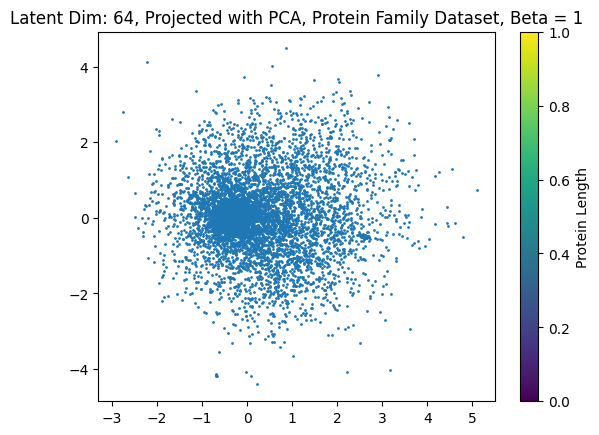

In [151]:
import matplotlib.pyplot as plt
plt.scatter(projected_data[:, 0], projected_data[:, 1], s = 1) #c=lengths[:projected_data.shape[0]], cmap='viridis')
plt.colorbar(label = 'Protein Length')
plt.title('Latent Dim: 64, Projected with PCA, Protein Family Dataset, Beta = 1')
plt.savefig("exp_1_latent_Pfam.png")

The most common protein family is: PF00069


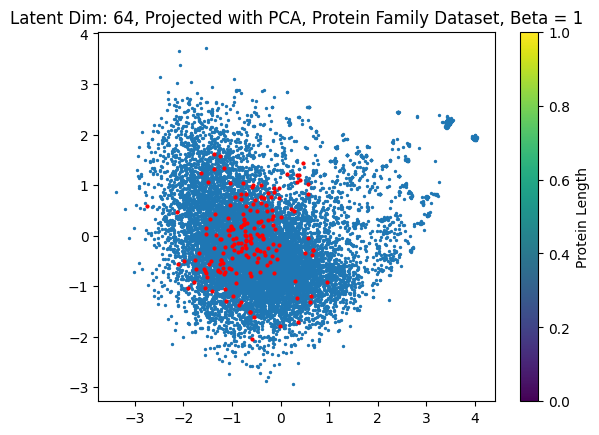

In [56]:
from collections import Counter
# Example list of strings
protein_families = families[:projected_data.shape[0]]
# Count occurrences of each element
counter = Counter(protein_families)

# Get the most common element (returns a list of tuples (element, count))
most_common = counter.most_common(1)

# Extract the most common string
if most_common:
    most_common_string = most_common[0][0]  # The string of the most common element
else:
    most_common_string = None

print(f"The most common protein family is: {most_common_string}")

family_array = np.array(protein_families)
most_common_indices = np.where((family_array == most_common_string) == 1)
most_common_points = projected_data[most_common_indices, :]

plt.scatter(projected_data[:, 0], projected_data[:, 1], s = 2)
plt.scatter(most_common_points.squeeze()[:, 0], most_common_points.squeeze()[:, 1], s = 4, c='r')

plt.colorbar(label = 'Protein Length')
plt.title('Latent Dim: 64, Projected with PCA, Protein Family Dataset, Beta = 1')
plt.savefig("exp_1_latent_Pfam.png")

In [1]:
dummy_out = torch.randn(128,500,24)

NameError: name 'torch' is not defined